# Perovskite-Si tandem cell with pyramidal surfaces

This example shows how you can simulate a perovskite-Si tandem cell with pyramidal surface textures, where the perovskite and other surface layers are assumed to be deposited conformally (i.e., also in a pyramid shape) on top of the Si. The perovskite optical constants are from [this paper](https://pubs.acs.org/doi/pdf/10.1021/acsenergylett.8b00089). We will calculate total reflection, transmission and absorption per layer as well as the wavelength-dependent absorption profiles in the perovskite and Si, which can be used in e.g. device simulations.

First, import relevant packages and RayFlare functions:

In [10]:
import numpy as np

from solcore.structure import Layer
from solcore import material

from rayflare.textures import regular_pyramids
from rayflare.options import default_options
from rayflare.ray_tracing import rt_structure
import matplotlib.pyplot as plt
import seaborn as sns

from cycler import cycler

Now we set some relevant options. We will scan across 20 x 20 surface points of the pyramid unit cell between 300 and 1200 nm, for unpolarized, normally-incident light. The `randomize_surface` option is set to True to prevent [correlation between the incident position on the front and rear pyramids](https://aip.scitation.org/doi/pdf/10.1063/1.339189). The `n_jobs` option is set to -1, which means that all available cores will be used. If you want to use all but one core, change this to -2 etc. We also need to provide a `project_name` to save the lookup tables which will be calculated using TMM and used during ray-tracing.

In [11]:
wavelengths = np.linspace(300, 1200, 40) * 1e-9

options = default_options()
options.wavelengths = wavelengths
options.nx = 20
options.ny = options.nx
options.n_rays = 4 * options.nx**2
options.depth_spacing = 1e-9
options.pol = "u"
options.I_thresh = 1e-3
options.project_name = "perovskite_Si_rt"
options.randomize_surface = True
options.n_jobs = -1 # use all cores; to use all but one, change to -2 etc.

We define our materials. Note that some of these are custom materials added to the database; we only need to do this once (to run this on your own computer, please run the perovskite_Si_rt.py file from the examples folder). We then define the front layer stack (i.e. all the materials which are on top of the Si, excluding Si itself, which will be the 'bulk' material) and the rear layer stack. Layer stacks are always defined starting with the layer closest to the top of the cell.

In [12]:
Si = material("Si")()
Air = material("Air")()
MgF2 = material("MgF2_RdeM")()
ITO_back = material("ITO_lowdoping")()
Perovskite = material("Perovskite_CsBr_1p6eV")()
Ag = material("Ag_Jiang")()
aSi_i = material("aSi_i")()
aSi_p = material("aSi_p")()
aSi_n = material("aSi_n")()
LiF = material("LiF")()
IZO = material("IZO")()
C60 = material("C60")()

# stack based on doi:10.1038/s41563-018-0115-4
front_materials = [
    Layer(100e-9, MgF2),
    Layer(110e-9, IZO),
    Layer(15e-9, C60),
    Layer(1e-9, LiF),
    Layer(440e-9, Perovskite),
    Layer(6.5e-9, aSi_n),
    Layer(6.5e-9, aSi_i),
]

back_materials = [Layer(6.5e-9, aSi_i), Layer(6.5e-9, aSi_p), Layer(240e-9, ITO_back)]

Now we define our front and back surfaces, including `interface_layers`. We will use regular pyramids for both the front and back surface; these pyramids point out on both sides, but since the direction of the pyramids is defined relative to the front surface, we must set `upright=True` for the top surface and `upright=False` for the rear surface. We also gives the surfaces a name (used to save the lookup table data) and ask RayFlare to calculate the absorption profile in the 5th layer, which is the perovskite.

In [13]:
triangle_surf = regular_pyramids(
    elevation_angle=55,
    upright=True,
    size=1,
    interface_layers=front_materials,
    name="coh_front",
    prof_layers=[5],
)

triangle_surf_back = regular_pyramids(
    elevation_angle=55,
    upright=False,
    size=1,
    interface_layers=back_materials,
    name="Si_back",
)

Now we make our ray-tracing structure by combining the front and back surfaces, specifying the material in between (Si) and setting its width to 260 microns. In order to use the TMM lookuptables to calculate reflection/transmission/absorption probabilities we must also set `use_TMM=True`.

In [14]:
rtstr_coh = rt_structure(
    textures=[triangle_surf, triangle_surf_back],
    materials=[Si],
    widths=[260e-6],
    incidence=Air,
    transmission=Ag,
    use_TMM=True,
    options=options,
    save_location="current",
)

# calculate:
result_coh = rtstr_coh.calculate(options)

Pre-computing TMM lookup table(s)
Existing lookup table found
Existing lookup table found


Now we define the same surfaces and structures again, except now we will treat all the layers incoherently (i.e. no thin-film interference) in the TMM.

In [15]:
triangle_surf = regular_pyramids(
    elevation_angle=55,
    upright=True,
    size=1,
    interface_layers=front_materials,
    coherency_list=["i"] * len(front_materials),
    name="inc_front",
    prof_layers=[5],
)

triangle_surf_back = regular_pyramids(
    elevation_angle=55,
    upright=False,
    size=1,
    interface_layers=back_materials,
    coherency_list=["i"] * len(back_materials),
    name="inc_back",
)

rtstr_inc = rt_structure(
    textures=[triangle_surf, triangle_surf_back],
    materials=[Si],
    widths=[260e-6],
    incidence=Air,
    transmission=Ag,
    use_TMM=True,
    options=options,
    save_location="current",
)

result_inc = rtstr_inc.calculate(options)

Pre-computing TMM lookup table(s)
Existing lookup table found
Existing lookup table found


Now we plot the results for reflection, transmission, and absorption per layer for both the coherent and incoherent cases.

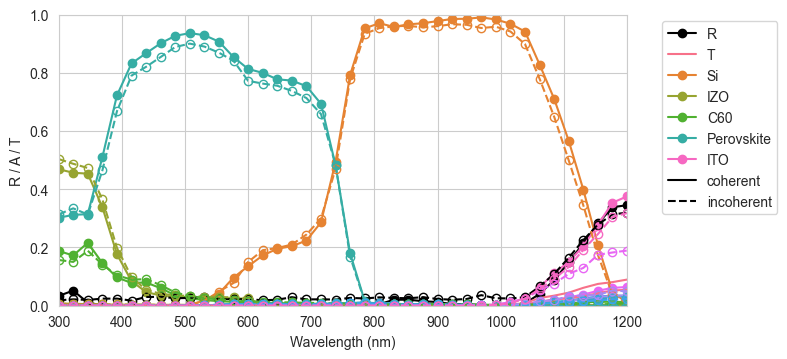

In [16]:
pal = sns.color_palette("husl", n_colors=len(front_materials) + len(back_materials) + 2)

cols = cycler("color", pal)

params = {
    "axes.prop_cycle": cols,
}

plt.rcParams.update(params)


fig = plt.figure(figsize=(8, 3.7))
plt.subplot(1, 1, 1)
plt.plot(wavelengths * 1e9, result_coh["R"], "-ko", label="R")
plt.plot(wavelengths * 1e9, result_coh["T"], mfc="none", label="T")
plt.plot(wavelengths * 1e9, result_coh["A_per_layer"][:, 0], "-o", label='Si')
plt.plot(wavelengths * 1e9, result_coh["A_per_interface"][0], "-o",
         label=[None, "IZO", "C60", None, "Perovskite", None, None])
plt.plot(wavelengths * 1e9, result_coh["A_per_interface"][1], "-o",
         label=[None, None, "ITO"])

plt.plot(wavelengths * 1e9, result_inc["R"], "--ko", mfc="none")
plt.plot(wavelengths * 1e9, result_inc["T"], mfc="none")
plt.plot(wavelengths * 1e9, result_inc["A_per_layer"][:, 0], "--o", mfc="none")
plt.plot(wavelengths * 1e9, result_inc["A_per_interface"][0], "--o", mfc="none")
plt.plot(wavelengths * 1e9, result_inc["A_per_interface"][1], "--o", mfc="none")

plt.plot([300, 301], [0, 0], "-k", label="coherent")
plt.plot([300, 301], [0, 0], "--k", label="incoherent")
plt.xlabel("Wavelength (nm)")
plt.ylabel("R / A / T")
plt.ylim(0, 1)
plt.xlim(300, 1200)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

We also plot the absorption profiles, for wavelengths up to 800 nm, in the perovskite.

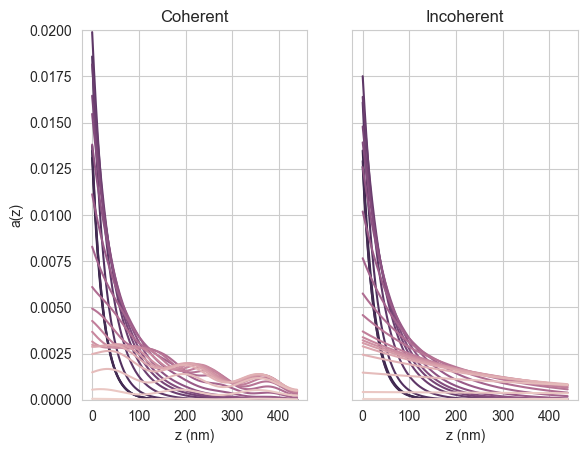

In [17]:
wl_Eg = wavelengths < 800e-9

pal = sns.cubehelix_palette(sum(wl_Eg), reverse=True)
cols = cycler("color", pal)
params = {
    "axes.prop_cycle": cols,
}
plt.rcParams.update(params)

pos = np.arange(0, 440, options.depth_spacing*1e9)

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(pos, result_coh["interface_profiles"][0][wl_Eg].T)
ax1.set_ylim(0, 0.02)
ax1.set_xlabel("z (nm)")
ax1.set_ylabel("a(z)")
ax1.set_title("Coherent")
ax2.plot(pos, result_inc["interface_profiles"][0][wl_Eg].T)
ax2.set_ylim(0, 0.02)
ax2.yaxis.set_ticklabels([])
ax2.set_xlabel("z (nm)")
ax2.set_title("Incoherent")
plt.show()

We see that, as expected, the coherent case shows interference fringes while the incoherent case does not. We can also plot the absorption profile in the Si (> 800 nm):

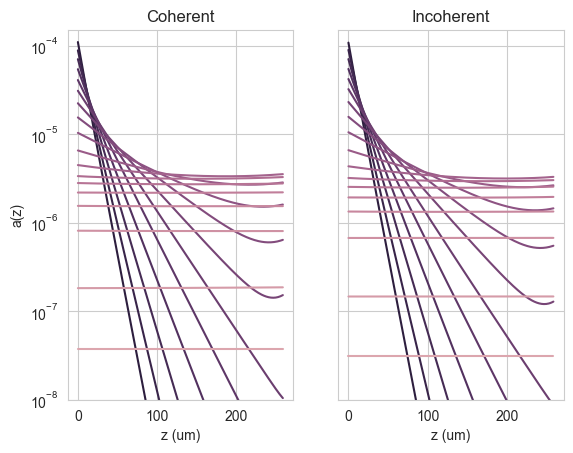

In [18]:
pos_bulk = pos = np.arange(0, 260, options.depth_spacing_bulk*1e6)
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.semilogy(pos, result_coh["profile"][~wl_Eg].T)
ax1.set_ylim(1e-8, 0.00015)
ax1.set_xlabel("z (um)")
ax1.set_ylabel("a(z)")
ax1.set_title("Coherent")
ax2.semilogy(pos, result_inc["profile"][~wl_Eg].T)
ax2.set_ylim(1e-8, 0.00015)
ax2.yaxis.set_ticklabels([])
ax2.set_xlabel("z (um)")
ax2.set_title("Incoherent")
plt.show()